In [8]:
import os
import numpy as np
import ccgpack as ccg
import pylab as plt
%matplotlib inline



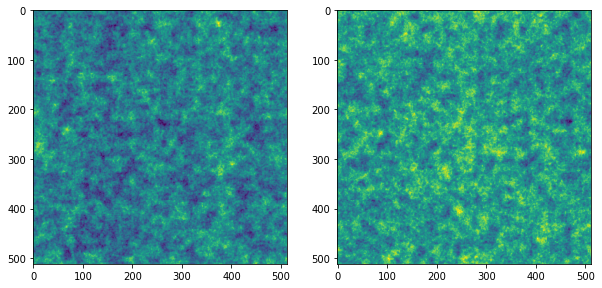

In [9]:
data1 = np.loadtxt('../../../MASTERs/moshen/ffcf/deh/maps/1')
data2 = np.loadtxt('../../../MASTERs/moshen/ffcf/deh/maps/2')

fig, (ax1,ax2) = plt.subplots(ncols=2,nrows=1,figsize=(10,5))
ax1.imshow(data1)
ax2.imshow(data2)

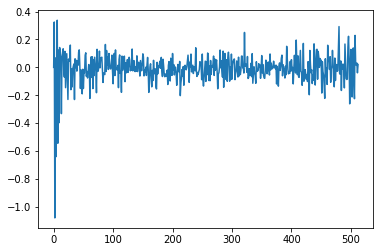

In [16]:
corr,error = ccg.tools.cross_correlarion_fucntion(data1,data2,100000)

plt.plot(corr)